# Download sliced data using MOTU-Client in Copernicus
### Written by Minh Phan

**WE DO NOT USE DATA GENERATED FROM THIS NOTEBOOK IN OUR DEMO**

Most of our data is obtained from Copernicus, "the Earth Observation component of the European Union’s space programme, looking at our planet and its environment for the benefit of Europe’s citizens" (copernicus.eu). Copernicus data, aside from traditional download methods using ERDDAP, also offers downloading using MOTU Service, "a Web Server allowing to handle and extract oceanographic huge volumes of data, creating the connection between heterogeneous data providers and end-users" (help.marine.copernicus.eu), if available. More information on MOTU can be accessed [here](https://help.marine.copernicus.eu/en/articles/4796533-what-are-the-motu-apis). 

Make sure to register for a Copernicus account in order to access the data.

In [1]:
! pip install motuclient

  Using cached motuclient-3.0.0-py3-none-any.whl


## Store credentials in bash

For security purposes, you can store your account credentials in your bash profile if you don't want others to know yours. If you fork this notebook on your local machine and are sure that your credentials cannot be exposed anywhere else, you can skip the hassle of saving them to bash and set them as Python variables, then feed them to the prompt generator. 

Make sure to change your username and password of your Copernicus/MOTU account to the two lines below for bash...

In [52]:
! echo 'export motu_password=YOURPASSWORD' >~/.bash_profile

In [54]:
! echo 'export motu_username=YOURUSERNAME' >>~/.bash_profile

In [6]:
# Vim will get stuck in this cell if you don't stop the cell. As soon as you see the two lines
# stop the execution and move on to the next cell.
! vim ~/.bash_profile

In [58]:
! source ~/.bash_profile

 **IMPORTANT** Please restart your server for the changes to take effect

In [48]:
# confirm that it is shown before proceeding
! echo $motu_username

## MOTU download prompt breakdown

Like ERDDAP URLs, MOTU works by sending requests to the API server. Unlike the former, it works through command line requests instead of URLs requests. Again, to prevent overloadding, we will break down the process to smaller time ranges to download. 

Here's an example of a MOTU API request

<div style="display: inline"> python -m motuclient --motu https://my.cmems-du.eu/motu-web/Motu --service-id GLOBAL_MULTIYEAR_BGC_001_029-TDS --product-id cmems_mod_glo_bgc_my_0.25_P1D-m --longitude-min 60 --longitude-max 80 --latitude-min 5 --latitude-max 25 --date-min "2020-12-31 00:00:00" --date-max "2020-12-31 23:59:59" --depth-min 0.5057600140571594 --depth-max 16.525320053100586 --variable chl --variable po4 --variable no3 --out-dir [OUTPUT_DIRECTORY] --out-name [OUTPUT_FILENAME] --user [USERNAME] --pwd [PASSWORD] </div>

As you can see, we have to provide all the parameters in order for the request to work, with temporal and lat/lon ranges being required on all datasets and depth range required only for some.  We also have to provide username and password (that we have after creating the Copernicus account) , as well as where we are going to store the data (output directory and name).

## Import necessary libraries

In [13]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob, subprocess

## Download data

In [16]:
def prompt_generator(params, temp_folder_path):
    months = pd.date_range(params['coords']['date-min'], params['coords']['date-max'], freq='M')
    prompts = []
    
    for m in months:
        prompt = f"motuclient --motu https://my.cmems-du.eu/motu-web/Motu --service-id {params['SERVICE_ID']}-TDS --product-id {params['PRODUCT_ID']} " + \
        f"--user {os.environ['motu_username']} --pwd {os.environ['motu_password']} --out-dir {temp_folder_path} --out-name {m.strftime('%Y%m')}.nc "
        prompt += f"--date-min '{m.strftime('%Y-%m')}-01 00:00:00' --date-max '{m.strftime('%Y-%m-%d')} 23:59:00' "
        for var in params['variables']:
            prompt += f'--variable {var} '
        for coord_name, coord_value in params['coords'].items():
            # since we already work 
            if coord_name not in ['date-min', 'date-max']:
                prompt += f'--{coord_name} {coord_value} '
        
        prompts.append(prompt)
        
    return prompts


def download_motu_api(params):
    # create new folder to store data
    MAIN_FOLDER = 'demonstrated data/motu'
    TEMP_FOLDER = params['PRODUCT_ID']
    path_temp_folder = os.path.join(MAIN_FOLDER, TEMP_FOLDER)
    
    if not os.path.exists(path_temp_folder):
        os.makedirs(path_temp_folder)

    # generate prompts to feed into the downloader
    prompts = prompt_generator(params, path_temp_folder)
    for prompt in prompts:
        process = subprocess.Popen(prompt.split())
        process.wait()
        

Next, we're going to initialize our parameters to download the data. The template is shown below, and werecommend you to choose a spatial range slightly larger than your actual region of interest due to cutoffs that may happen at the edges.

In [20]:
# modify your parameters as you wish to feed into prompt generator
# here's mine to download chlorophyll-a data
var_chlorophyll = {
    'SERVICE_ID': 'OCEANCOLOUR_GLO_BGC_L4_MY_009_104',
    'PRODUCT_ID': 'cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D',
    'variables': ['CHL', 'CHL_uncertainty'],
    'coords': {
        'longitude-min': 60, 
        'longitude-max': 80,
        'latitude-min': 5,
        'latitude-max': 25,
        'date-min': '2000-01',
        'date-max': '2002-01' # exclusive of last month, so in this case, we get data until DEC '02
        # optional coordinate params for some datasets: 'depth-min', 'depth-max'
        # consult data access page for more information
    }
}

var_sla = {
    'SERVICE_ID': 'SEALEVEL_GLO_PHY_L4_MY_008_047',
    'PRODUCT_ID': 'cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D',
    'variables': ['adt', 'sla'],
    'coords': {
        'longitude-min': 60,
        'longitude-max': 80,
        'latitude-min': 5,
        'latitude-max': 25,
        'date-min': '2000-01',
        'date-max': '2002-01' # exclusive of last month, so in this case, we get data until DEC '02
    }
}

In [17]:
download_motu_api(var_sla)

2023-07-11 04:31:55.819 [ INFO] Asynchronous mode set
2023-07-11 04:31:55.819 [ INFO] Authenticating user mphan for service https://my.cmems-du.eu/motu-web/Motu
2023-07-11 04:32:04.748 [ INFO] Requesting file to download (this can take a while)...
2023-07-11 04:32:14.896 [ INFO] Authenticating user mphan for service https://my.cmems-du.eu/motu-web/Motu
2023-07-11 04:32:32.754 [ INFO] The product is ready for download
2023-07-11 04:32:32.754 [ INFO] Downloading file (this can take a while)...
2023-07-11 04:32:33.680 [ INFO] File type: application/x-netcdf
2023-07-11 04:32:33.680 [ INFO] File size: 3.3 MB (3260684 B)
2023-07-11 04:32:33.680 [ INFO] Downloading file /home/jovyan/shared/minh-notebooks/motu/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D/200001.nc
2023-07-11 04:32:34.029 [ INFO] Progress -   3.3 MB (2.0%)
2023-07-11 04:32:34.204 [ INFO] Progress -   3.3 MB (4.0%)
2023-07-11 04:32:34.379 [ INFO] Progress -   3.3 MB (6.0%)
2023-07-11 04:32:34.380 [ INFO] Progress -   

**DISCLAIMER**: Downloading time may be extremely slow due to processing time from Motu for each request. We can increase temporal range for each one (6 months or 1 year, for example) but it may exceed the size limit MOTU allows. Feel free to modify the prompt generation as it fits to balance speed and size.



## Combine data

In [18]:
ds = xr.open_mfdataset('demonstrated data/motu/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D//*.nc')

In [19]:
ds

<xarray.Dataset>
Dimensions:    (time: 731, latitude: 81, longitude: 81)
Coordinates:
  * latitude   (latitude) float32 4.875 5.125 5.375 5.625 ... 24.38 24.62 24.88
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * longitude  (longitude) float32 59.88 60.12 60.38 60.62 ... 79.38 79.62 79.88
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(31, 81, 81), meta=np.ndarray>
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(31, 81, 81), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Sea Surface Height measur...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1D
    time_coverage_end:                              2022-08-04T12:00:00Z
    time_coverage_resolution:                       P1D
    time_coverage_start:                            2022-08-03T12:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

# Additional data (clean later)

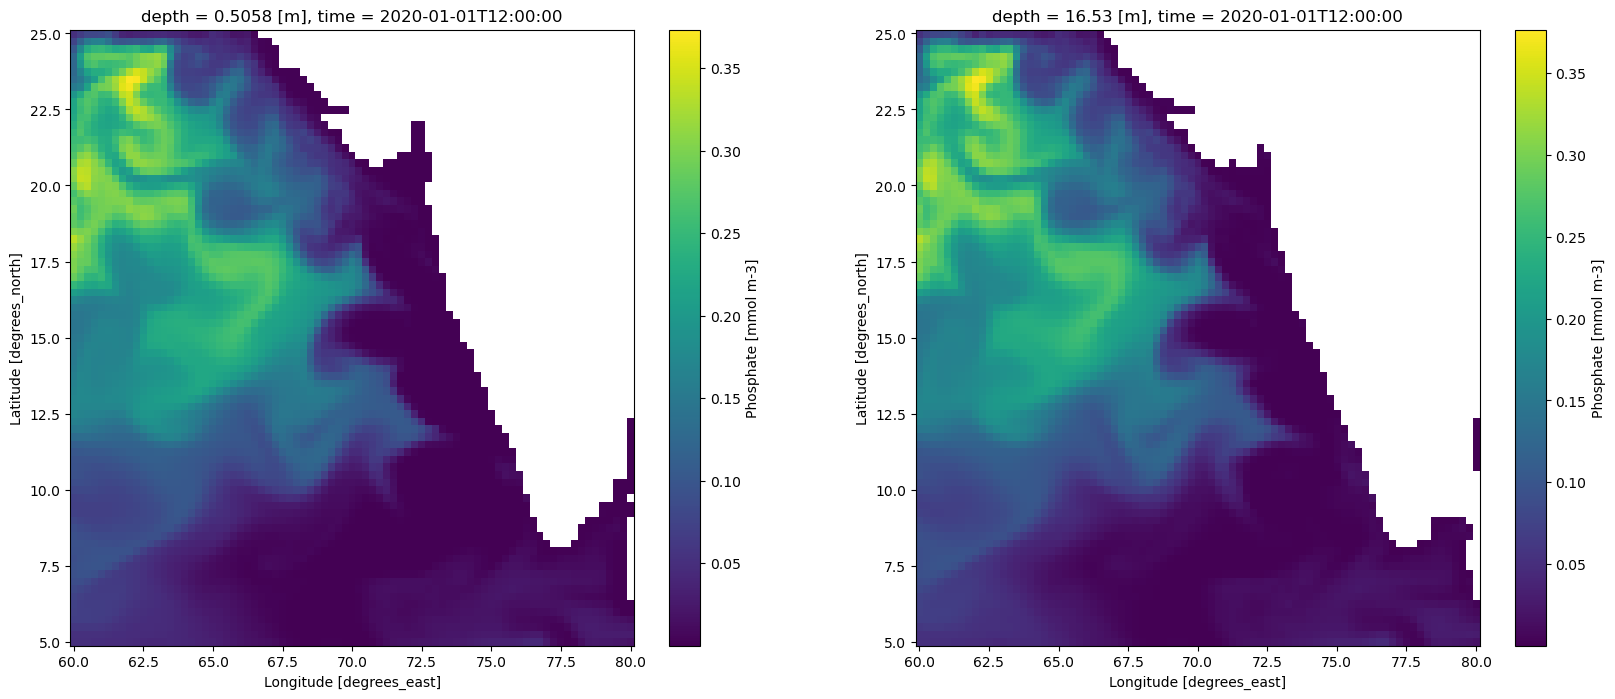

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
motu.isel(time=0, depth=0)['po4'].plot.imshow(ax=axs[0])
motu.isel(time=0, depth=10)['po4'].plot.imshow(ax=axs[1])

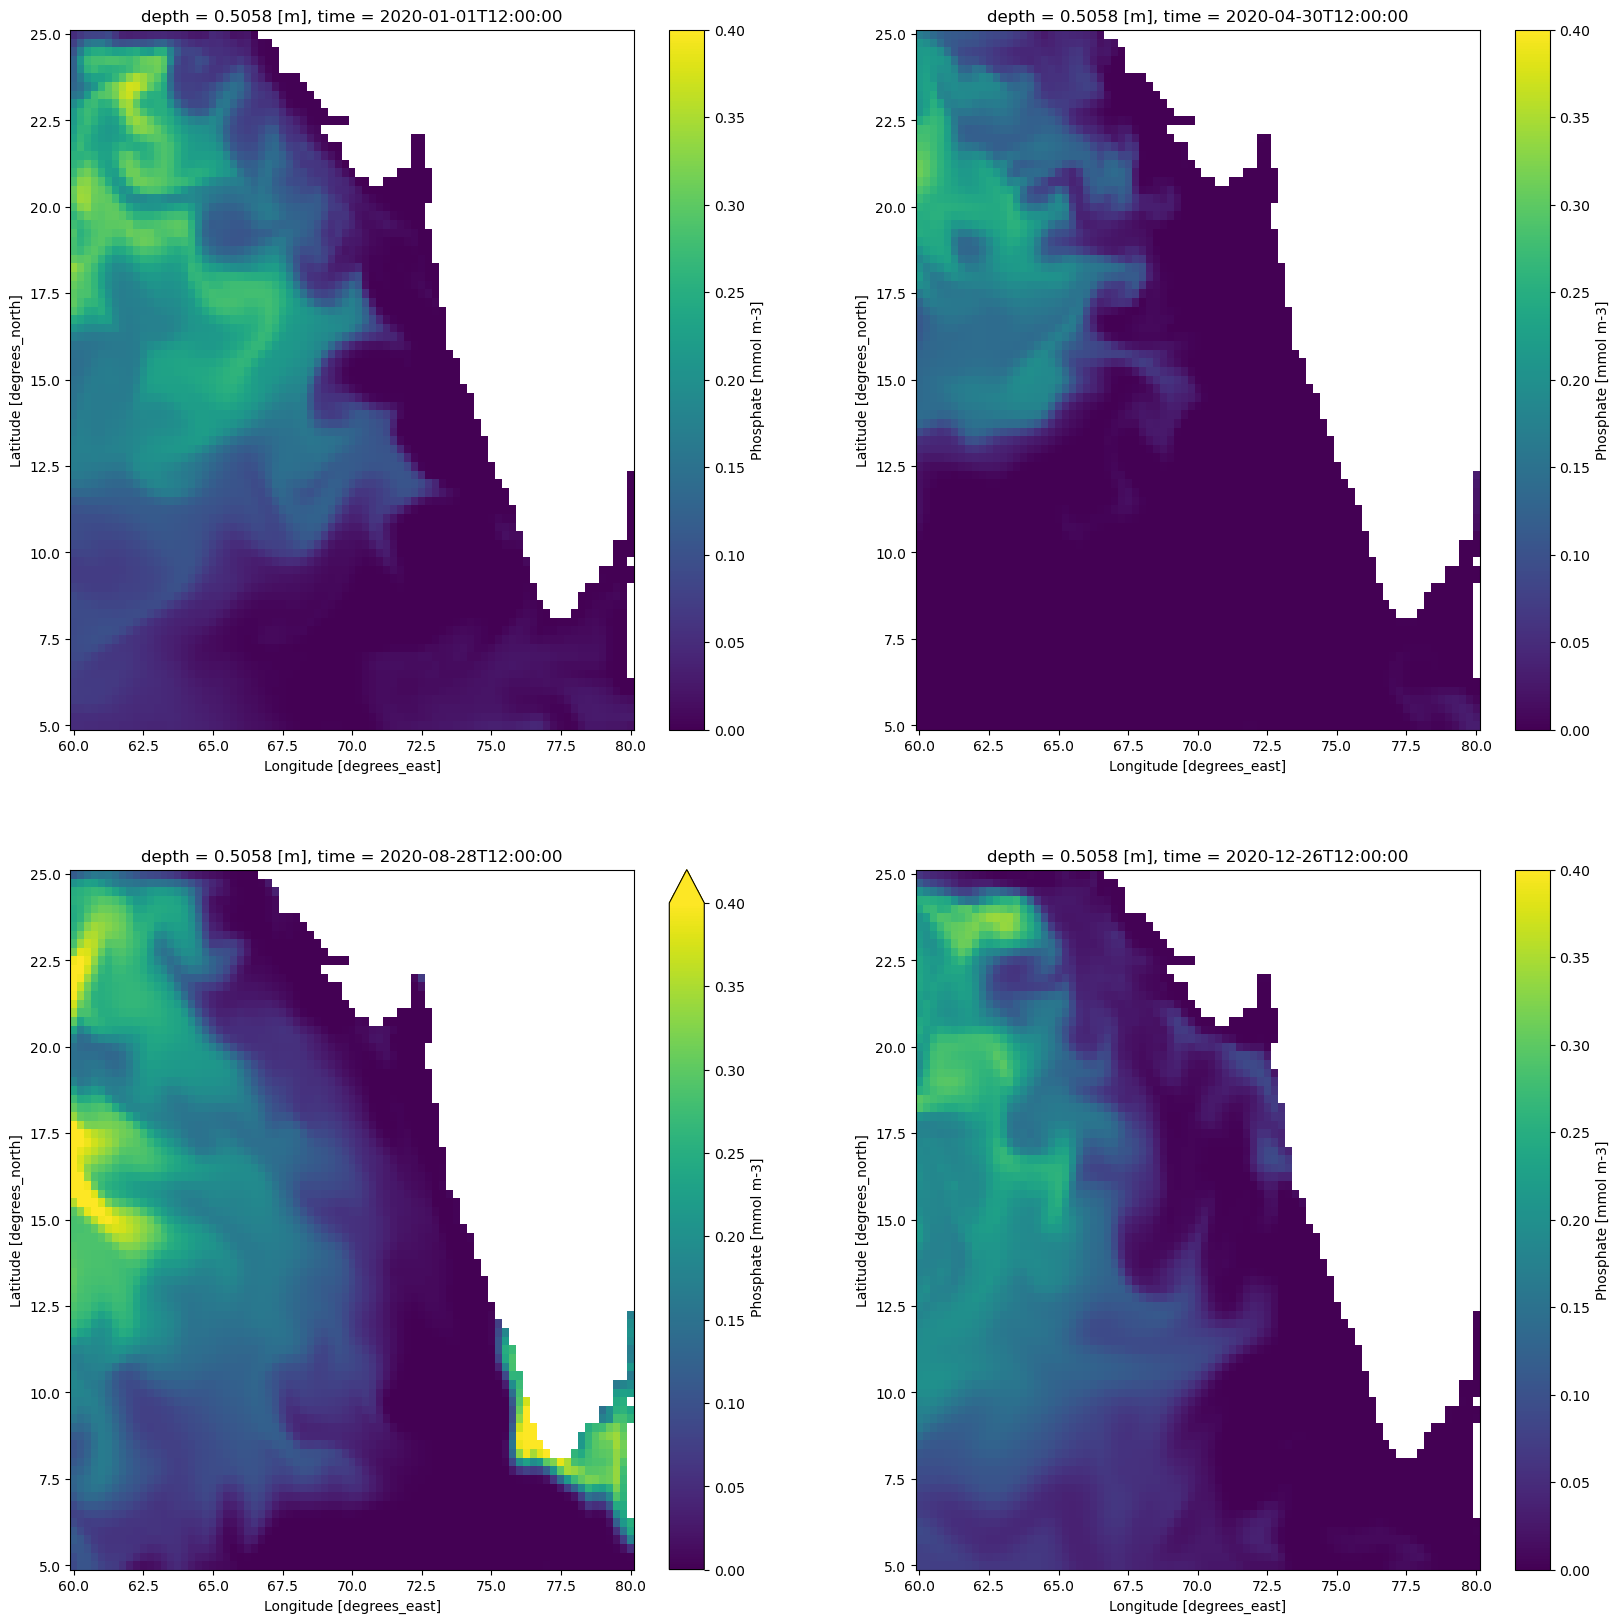

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))
motu.isel(time=0, depth=0)['po4'].plot.imshow(ax=axs[0][0], vmin=0, vmax=0.4)
motu.isel(time=120, depth=0)['po4'].plot.imshow(ax=axs[0][1], vmin=0, vmax=0.4)
motu.isel(time=240, depth=0)['po4'].plot.imshow(ax=axs[1][0], vmin=0, vmax=0.4)
motu.isel(time=360, depth=0)['po4'].plot.imshow(ax=axs[1][1], vmin=0, vmax=0.4)